# How to Automate Data Cleaning with AI <a id="make-a-data-cleaning-agent"></a>

In this tutorial, you will learn how to automate data cleaning with AI. It can automatically:

- detect and fix common data cleaning issues
- missing values
- duplicate rows
- inconsistent data types. 
 
By using this AI agent, you can save time and effort on data cleaning, allowing you to focus on more important tasks.

### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)


# Table of Contents

1. [Make A Data Cleaning Agent](#make-a-data-cleaning-agent)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Load a Dataset](#load-a-dataset)
5. [Create The Agent](#create-the-agent)
6. [Response](#response)
7. [The cleaning recipe](#the-cleaning-recipe)
8. [Data Cleaner Function](#data-cleaner-function)
9. [Cleaned Data As Pandas Data Frame](#cleaned-data-as-pandas-data-frame)
10. [Free Generative AI Data Science Workshop](#free-generative-ai-data-science-workshop)

### Load Libraries <a id="load-libraries"></a>

In [56]:
# * Libraries

from langchain_openai import ChatOpenAI
import os
import yaml
import pandas as pd
from pprint import pprint

from ai_data_science_team.agents import DataCleaningAgent

### Setup AI and Logging <a id="setup-ai-and-logging"></a>

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files during the AI Data Science Teams processing of files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [57]:
MODEL    = "gpt-4o-mini"
LOG      = True
LOG_PATH = os.path.join(os.getcwd(), "logs/")

os.environ["OPENAI_API_KEY"] = ""


llm = ChatOpenAI(model = MODEL)

llm



ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000025FF84A0310>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000025E41096F90>, root_client=<openai.OpenAI object at 0x0000025E97EA0C90>, root_async_client=<openai.AsyncOpenAI object at 0x0000025FF84BE010>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

### Load a Dataset <a id="load-a-dataset"></a>

Next, let's load a customer churn data set that we will clean up. 

In [58]:
#df = pd.read_csv("https://raw.githubusercontent.com/business-science/ai-data-science-team/refs/heads/master/data/churn_data.csv")
df = pd.read_csv("../Datasets_P1/df_Cost.csv")
df
df

C:\Users\lukep\AppData\Local\Temp\ipykernel_2084\1213278816.py:2: DtypeWarning: Columns (8,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Datasets_P1/df_Cost.csv")


,rpt_rec_num,Provider_CCN,Facility_Name,Street_Address,City,State_Code,Zip_Code,County,Medicare_CBSA_Number,Rural_versus_Urban,...,Total_Current_Assets,Total_Other_Income,SNF_Bed_Days_Available,Leasehold_improvements,Mortgage_payable,Notes_and_Loans_Payable_(short_term),Land,Inventory,Prepaid_expenses,Year
0,1089712,495134,RIDGECREST MANOR NURSING & REHAB CTR,157 ROSS-CARTER BLVD,DUFFIELD,VA,24244,SCOTT,28700.0,U,...,1439227.0,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
1,1091410,75417,REGENCY HEIGHTS OF NORWICH LLC,60 CROUCH AVENUE,NORWICH,CT,6360,NEW LONDON,35980.0,U,...,980150.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
2,1093283,165252,WESTVIEW ACRES CARE CENTER,203 SW LORRAINE,LEON,IA,50144,DECATUR,99916.0,R,...,244239.0,8392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
3,1095547,225497,VERO HEALTH & REHAB PARKWAY,1190 VFW PARKWAY,WEST ROXBURY,MA,2132,SUFFOLK,14454.0,U,...,1728824.0,2668.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
4,1095966,265161,WILSONS CREEK NURSING & REHAB,3403 WEST MT VERNON,SPRINGFIELD,MO,65802,GREENE,44180.0,U,...,807209.0,4474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106264,1365869,505453,KIN ON HEALTH CARE CENTER,4416 SOUTH BRANDON,SEATTLE,WA,98118,KING,42644.0,U,...,2873216.0,129009.0,36500.0,3385586.0,NaN,NaN,764446.0,134638.0,94824.0,2021
106265,1365888,675765,LCS-WP LLC DBA WALNUT PLACE,5515 GLEN LAKES DRIVE,DALLAS,TX,75231,DALLAS,19124.0,U,...,3737959.0,1263196.0,112420.0,2019550.0,17800000.0,1132887.0,3840000.0,NaN,231082.0,2021
106266,1365889,675932,STRATFORD HOSPITAL DISTRICT DBA ARBO,609 RIO CONCHO DRIVE,SAN ANGELO,TX,76903-6029,TOM GREEN,41660.0,U,...,22991000.0,525534.0,45990.0,NaN,NaN,NaN,NaN,NaN,53248.0,2021
106267,1365890,675956,WINDSOR NRS & REHAB CTR OF DUVAL,5301 W. DUVAL ROAD,AUSTIN,TX,78727,TRAVIS,12420.0,U,...,1345068.0,3738132.0,75190.0,711584.0,NaN,1378931.0,NaN,NaN,20465.0,2021


### Create The Agent <a id="create-the-agent"></a>

Run this code to create an agent with `make_data_cleaning_agent()`.

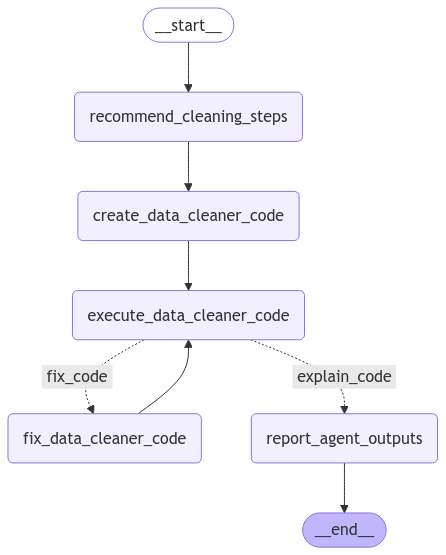

In [59]:
data_cleaning_agent = DataCleaningAgent(
    model = llm, 
    log=LOG, 
    log_path=LOG_PATH
)

data_cleaning_agent

This creates an `app`, which is a langgraph agent with the main inputs:

- **user_instructions**: The data cleaning agent will use these comments to modify the "standard recipe" 
  - Standard Recipe: The standard cleaning recipe which includes removing columns with more than 40% missing values, imputing missing values using mean (numeric) or mode (categorical), removing duplicate rows, and removing outliers. 
- **data_raw**: The raw data to be cleaned
- **max_retries**: Used to limit the number of attempts to fix the python code generated by the agent. Set this to 3 to limit to 3 attempts. 
- **retry_count**: Set this to 0. 

data_cleaning_agent.invoke_agent(
    data_raw=df,
    user_instructions=""" 
    Handling Missing Data  
    - Do not automatically remove columns with high missing values. Instead:  
        - Keep business-critical columns even if they have >40% missing data.  
        - Suggest advanced imputation methods (e.g., regression, KNN imputation) instead of deletion.  
    - Numeric Data: Use median imputation instead of the mean, as financial data often contains skewed distributions.  
    - Categorical Data: Use decision tree-based imputation or create an 'Unknown' category instead of defaulting to the mode.  
    - Only remove rows with missing values if they lack critical information (e.g., transaction IDs, account balances).  

    2. Outlier Detection & Treatment  
    - Identify outliers using IQR (Interquartile Range) or Z-score but do not remove them outright. Instead:  
        - Flag extreme values rather than discarding them.  
        - Suggest Winsorization or log transformations if needed.  

    3. Standardization & Normalization  
    - Ensure numerical consistency by scaling financial values appropriately:  
        - Apply Z-score standardization for regression models.  
        - Use Min-Max scaling if preparing for machine learning models.  

    4. Data Type Corrections  
    - Convert date columns to datetime format.  
    - Ensure categorical variables are properly formatted for analysis.  

    5. Duplicate Handling  
    - Remove only fully identical duplicate rows to prevent loss of meaningful data.  

    6. Feature Engineering (If Applicable)  
    - Create aggregates, moving averages, percentage changes, and financial ratios to enhance analysis.  
    - Generate dummy variables for categorical data instead of direct imputation.  

    7. Final Validation  
    - Provide a summary of the changes made.  
    - Ensure that the final dataset is clean, structured, and suitable for financial analysis while preserving key information.  

    **Output:** Provide the cleaned dataset along with a brief report summarizing the changes, imputation methods used, and any flagged issues (outliers, missing data, etc.).  
    """,
    max_retries=3,
    retry_count=0
)


In [60]:
data_cleaning_agent.invoke_agent(
    data_raw=df,
    user_instructions="Don't remove outliers. Don't remove columns at all",
    max_retries=3,
    retry_count=0
)


---DATA CLEANING AGENT----
    * RECOMMEND CLEANING STEPS
    * CREATE DATA CLEANER CODE
      File saved to: c:\Users\lukep\Documents\La Philly\Classes\Capstone\Files\logs/data_cleaner.py
    * EXECUTING AGENT CODE
Outliers summary based on IQR (above 3*IQR):
rpt_rec_num: 0 outliers
Provider_CCN: 0 outliers
Type_of_Control: 16803 outliers
Accounts_Receivable: 2854 outliers
Accounts_payable: 4946 outliers
Buildings: 4240 outliers
Cash_on_hand_and_in_banks: 7260 outliers
General_fund_balance: 9892 outliers
Gross_Revenue: 1506 outliers
Inpatient_PPS_Amount: 2258 outliers
Inpatient_Revenue: 1443 outliers
Less_Total_Operating_Expense: 2038 outliers
Less_discounts_on_patients: 3866 outliers
Major_movable_equipment: 3579 outliers
Net_Income: 4482 outliers
Net_Patient_Revenue: 1647 outliers
Number_of_Beds: 1329 outliers
Other_Assets: 2364 outliers
Other_current_liabilities: 3717 outliers
Overhead_Non_Salary_Costs: 2292 outliers
SNF_Admissions_Other: 2378 outliers
SNF_Admissions_Title_XIX: 330

### Response <a id="response"></a>

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [61]:
response = data_cleaning_agent.get_response()

list(response.keys())

['messages',
 'user_instructions',
 'recommended_steps',
 'data_raw',
 'data_cleaned',
 'all_datasets_summary',
 'data_cleaner_function',
 'data_cleaner_function_path',
 'data_cleaner_file_name',
 'data_cleaner_function_name',
 'data_cleaner_error',
 'max_retries',
 'retry_count']

#### Cleaned Data As Pandas Data Frame <a id="cleaned-data-as-pandas-data-frame"></a>

Use the `get_data_cleaned()` method to get the cleaned data as a pandas data frame.

In [62]:
df_new = data_cleaning_agent.get_data_cleaned()
data_cleaning_agent.get_data_cleaned()

,rpt_rec_num,Provider_CCN,Facility_Name,Street_Address,City,State_Code,Zip_Code,County,Medicare_CBSA_Number,Rural_versus_Urban,...,Total_Current_Assets,Total_Other_Income,SNF_Bed_Days_Available,Leasehold_improvements,Mortgage_payable,Notes_and_Loans_Payable_(short_term),Land,Inventory,Prepaid_expenses,Year
0,1089712.0,495134.0,RIDGECREST MANOR NURSING & REHAB CTR,157 ROSS-CARTER BLVD,DUFFIELD,VA,24244,SCOTT,28700.0,U,...,1439227.0,123.0,38205.855106,2.831266e+06,1.131023e+07,1.166857e+06,25000.0,78409.49521,172993.416185,2015.0
1,1091410.0,75417.0,REGENCY HEIGHTS OF NORWICH LLC,60 CROUCH AVENUE,NORWICH,CT,6360,NEW LONDON,35980.0,U,...,980150.0,7.0,38205.855106,2.831266e+06,1.131023e+07,1.166857e+06,25000.0,78409.49521,172993.416185,2015.0
2,1093283.0,165252.0,WESTVIEW ACRES CARE CENTER,203 SW LORRAINE,LEON,IA,50144,DECATUR,99916.0,R,...,244239.0,8392.0,38205.855106,2.831266e+06,1.131023e+07,1.166857e+06,25000.0,78409.49521,172993.416185,2015.0
3,1095547.0,225497.0,VERO HEALTH & REHAB PARKWAY,1190 VFW PARKWAY,WEST ROXBURY,MA,2132,SUFFOLK,14454.0,U,...,1728824.0,2668.0,38205.855106,2.831266e+06,1.131023e+07,1.166857e+06,25000.0,78409.49521,172993.416185,2015.0
4,1095966.0,265161.0,WILSONS CREEK NURSING & REHAB,3403 WEST MT VERNON,SPRINGFIELD,MO,65802,GREENE,44180.0,U,...,807209.0,4474.0,38205.855106,2.831266e+06,1.131023e+07,1.166857e+06,25000.0,78409.49521,172993.416185,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106264,1365869.0,505453.0,KIN ON HEALTH CARE CENTER,4416 SOUTH BRANDON,SEATTLE,WA,98118,KING,42644.0,U,...,2873216.0,129009.0,36500.000000,3.385586e+06,1.131023e+07,1.166857e+06,764446.0,134638.00000,94824.000000,2021.0
106265,1365888.0,675765.0,LCS-WP LLC DBA WALNUT PLACE,5515 GLEN LAKES DRIVE,DALLAS,TX,75231,DALLAS,19124.0,U,...,3737959.0,1263196.0,112420.000000,2.019550e+06,1.780000e+07,1.132887e+06,3840000.0,78409.49521,231082.000000,2021.0
106266,1365889.0,675932.0,STRATFORD HOSPITAL DISTRICT DBA ARBO,609 RIO CONCHO DRIVE,SAN ANGELO,TX,76903-6029,TOM GREEN,41660.0,U,...,22991000.0,525534.0,45990.000000,2.831266e+06,1.131023e+07,1.166857e+06,25000.0,78409.49521,53248.000000,2021.0
106267,1365890.0,675956.0,WINDSOR NRS & REHAB CTR OF DUVAL,5301 W. DUVAL ROAD,AUSTIN,TX,78727,TRAVIS,12420.0,U,...,1345068.0,3738132.0,75190.000000,7.115840e+05,1.131023e+07,1.378931e+06,25000.0,78409.49521,20465.000000,2021.0


#### Data Cleaner Function <a id="data-cleaner-function"></a>

We can use the `get_data_cleaner_function()` method to get the data cleaner function pipeline. 

- In Jupyter Notebooks, setting `markdown=True` will return the function as markdown code. 
- In Streamlit apps, it's recommended to set `markdown=False`.

In [63]:
data_cleaning_agent.get_data_cleaner_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: data_cleaning_agent
# Time Created: 2025-02-10 20:44:57

def data_cleaner(data_raw):
    import pandas as pd
    import numpy as np
    from sklearn.impute import SimpleImputer



    # Analyze data
    numeric_columns = data_raw.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = data_raw.select_dtypes(include=['object']).columns.tolist()

    # Step 2: Impute missing values for numeric columns
    numeric_imputer = SimpleImputer(strategy='mean')
    data_raw[numeric_columns] = numeric_imputer.fit_transform(data_raw[numeric_columns])
    
    # Step 3: Impute missing values for categorical columns
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    data_raw[categorical_columns] = categorical_imputer.fit_transform(data_raw[categorical_columns])

    # Step 4: Convert appropriate columns to correct data types
    data_raw['Fiscal_Year_Begin_Date'] = pd.to_datetime(data_raw['Fiscal_Year_Begin_Date'], errors='coerce')
    data_raw['Fiscal_Year_End_Date'] = pd.to_datetime(data_raw['Fiscal_Year_End_Date'], errors='coerce')

    # Step 5: Remove duplicate rows
    data_raw.drop_duplicates(inplace=True)

    # Step 6: Remove rows with missing values (if desired, otherwise can be commented out)
    data_raw.dropna(inplace=True)

    # Step 7: Check for and report extreme outliers using IQR method
    summary_outliers = {}
    for col in numeric_columns:
        Q1 = data_raw[col].quantile(0.25)
        Q3 = data_raw[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers_condition = (data_raw[col] < (Q1 - 3 * IQR)) | (data_raw[col] > (Q3 + 3 * IQR))
        outlier_count = outliers_condition.sum()
        summary_outliers[col] = outlier_count

    # Output summary of outliers
    print("Outliers summary based on IQR (above 3*IQR):")
    for col, count in summary_outliers.items():
        print(f"{col}: {count} outliers")

    # Step 8: Document data characteristics post-cleaning
    print("Data characteristics post-cleaning:")
    print(data_raw.info())

    return data_raw
```

#### Recommended Steps

To get the recommended steps during the data analysis (prior to coding), run the `get_recommended_steps()` method.

In [64]:
data_cleaning_agent.get_recommended_cleaning_steps(markdown=True)

# Recommended Data Cleaning Steps:
Here are the recommended steps to clean and preprocess the provided dataset, tailored to the specified user instructions and keeping in mind the data characteristics:

1. **Analyze Data for Initial Conditions**  
   - Conduct an overview of the dataset to identify the distributions, trends, and relationships between variables. This analysis will inform decisions on how to handle missing values and identify potential inconsistencies or anomalies.

2. **Impute Missing Values: Numeric Columns**  
   - For each numeric column with missing values, fill in the missing values with the column mean. This will help maintain the overall average of those numeric features.  
   ```python
   for col in numeric_columns:
       df[col].fillna(df[col].mean(), inplace=True)
   ```

3. **Impute Missing Values: Categorical Columns**  
   - For each categorical column with missing values, fill in the missing values with the mode of the column. This step helps retain the most frequent category, preserving the dataset's categorical integrity.  
   ```python
   for col in categorical_columns:
       df[col].fillna(df[col].mode()[0], inplace=True)
   ```

4. **Convert Columns to Correct Data Types**  
   - Ensure that all columns are in their appropriate data types. For instance, convert date columns to `datetime` type and ensure any numeric columns that need categorization (like `State_Code`) are appropriately set.  
   ```python
   df['Fiscal_Year_Begin_Date'] = pd.to_datetime(df['Fiscal_Year_Begin_Date'])
   df['Fiscal_Year_End_Date'] = pd.to_datetime(df['Fiscal_Year_End_Date'])
   # Additional conversions as needed
   ```

5. **Remove Duplicate Rows**  
   - Identify and remove any duplicate entries in the dataset. Duplicates can introduce bias and skew the analysis results.  
   ```python
   df.drop_duplicates(inplace=True)
   ```

6. **Remove Rows with Missing Values**  
   - Since the user has not set any thresholds for handling missing values but has requested to handle missing values through imputations, proceed with removing any remaining rows that still contain missing values, if desired, or keep them for further analysis.  
   ```python
   df.dropna(inplace=True)  # If desired
   ```

7. **Check for and Handle Extreme Outliers**  
   - While the user has requested not to remove outliers, it is still essential to identify them for reporting purposes. Provide a summary of outliers based on IQR (Interquartile Range) so that they can be assessed further if a future decision needs to be made. This step will also help in understanding data distribution.  
   ```python
   Q1 = df.quantile(0.25)
   Q3 = df.quantile(0.75)
   IQR = Q3 - Q1
   outliers = df[(df < (Q1 - 3 * IQR)) | (df > (Q3 + 3 * IQR))].any(axis=1)
   ```

8. **Document Data Characteristics Post-Cleaning**  
   - Summarize the state of the dataset after cleaning actions have taken place (e.g., counts of remaining NaN values, descriptions of cleaned columns, etc.). This provides a clear record of any changes made during cleaning.  

By following these steps, the data will be considerably cleaner and in better shape for analysis while adhering to the user's requirements and requests.

### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Missing Values Heatmap')

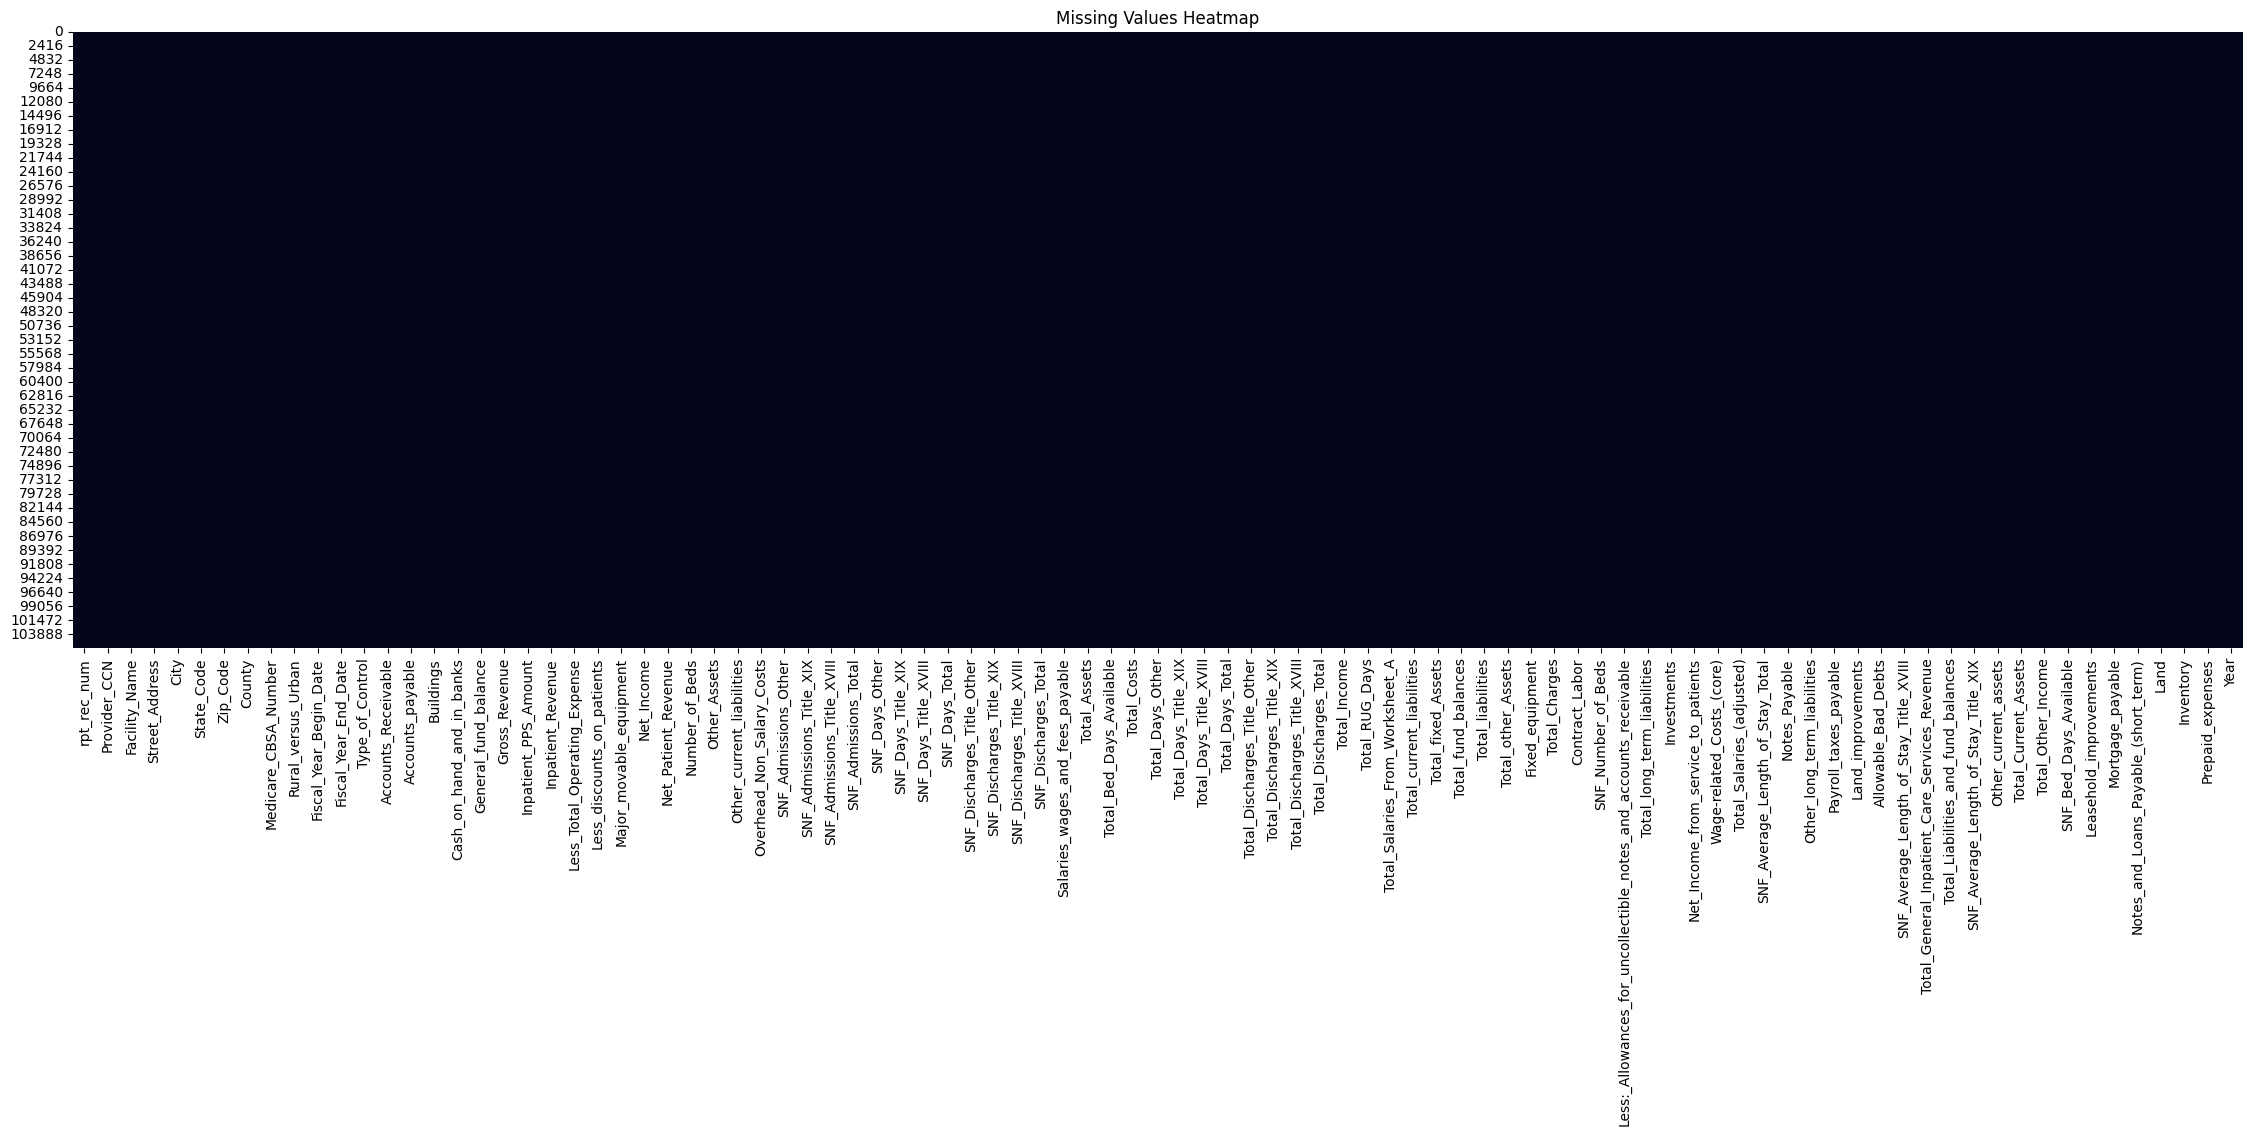

In [66]:
plt.figure(figsize=(28, 8))
sns.heatmap(df_new.isnull(), cbar=False)   # and do df21
plt.title("Missing Values Heatmap")

# Download the dataset: 

In [68]:
# Export df_Cost to a CSV file
df_new.to_csv('df_new2.csv', index=False)
# then move it to the dataset folder